In [3]:
import numpy as np
import sys
import os
import librosa
import torch

current_directory = os.getcwd()
project_dir = os.path.join(current_directory, '..')
print(project_dir)
sys.path.append(project_dir)

from utils import DanceToMusic
from transformers import EncodecModel
!pip install numpy==1.24

/home/azeez/Documents/projects/DanceToMusicApp/ml/notebooks/..


In [4]:
if torch.cuda.is_available():
        device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device = torch.device("cpu")


model_id = "facebook/encodec_24khz"
encodec_model = EncodecModel.from_pretrained(model_id)
codebook_size = encodec_model.quantizer.codebook_size
encodec_model.to(device)
sample_rate = 24000

data_dir = "/Users/azeez/Documents/pose_estimation/DanceToMusicApp/ml/data/samples/5sec_expando_dataset"
train_dataset = DanceToMusic(data_dir, encoder = encodec_model, sample_rate = sample_rate, device=device)

ValueError: max() arg is an empty sequence

In [ ]:
from IPython.display import Audio, display
audio_codes, pose, pose_mask, wav, wav_mask, wav_path, sample_rate = train_dataset[100]
print(wav.shape)
display(Audio(wav, rate=24000))


torch.Size([1, 120001])


## Bandpass Filtering and Spectral Subtraction
#### The goal of this experimentation is to try and reduce the compelxity of the audio samples.

In [ ]:
from scipy.signal import butter, lfilter

def bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, signal)
    return y

def spectral_subtraction(signal, sr = 24000, alpha=1.0):
    # Fourier Transform
    signal_fft = np.fft.fft(signal)
    signal_freqs = np.fft.fftfreq(len(signal), 1/sr)

    # Spectral subtraction
    subtracted_spectrum = np.abs(signal_fft) - alpha * np.mean(np.abs(signal_fft))
    subtracted_spectrum[subtracted_spectrum < 0] = 0

    # Reconstruct signal
    subtracted_signal = np.fft.ifft(subtracted_spectrum * np.exp(1j * np.angle(signal_fft)))
    return subtracted_signal.real

def bandpass_filter_and_subtraction(signal, sr = 24000, alpha  = 1.0, lowcut = 10, highcut = 100, order = 2):
    filtered_signal = bandpass_filter(signal, lowcut=lowcut, highcut=highcut, fs=sr, order = order)
    subtracted_signal = spectral_subtraction(filtered_signal, alpha=alpha)
    return subtracted_signal

subtracted_signal = bandpass_filter_and_subtraction(wav, lowcut=10, highcut=150, alpha=1.0, order=3)

display(Audio(subtracted_signal, rate=24000))

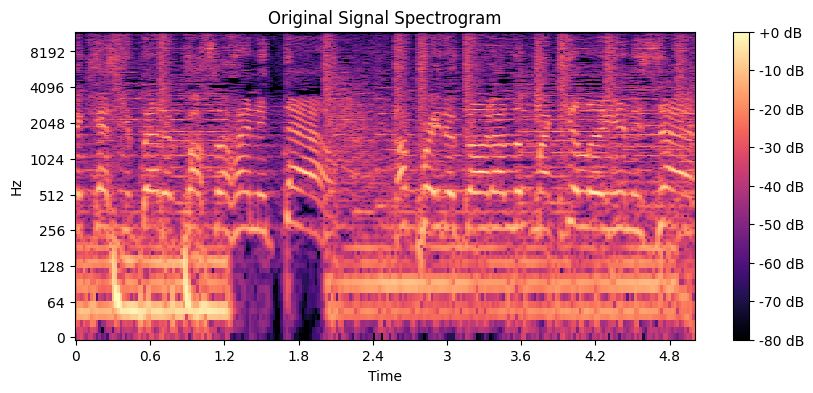

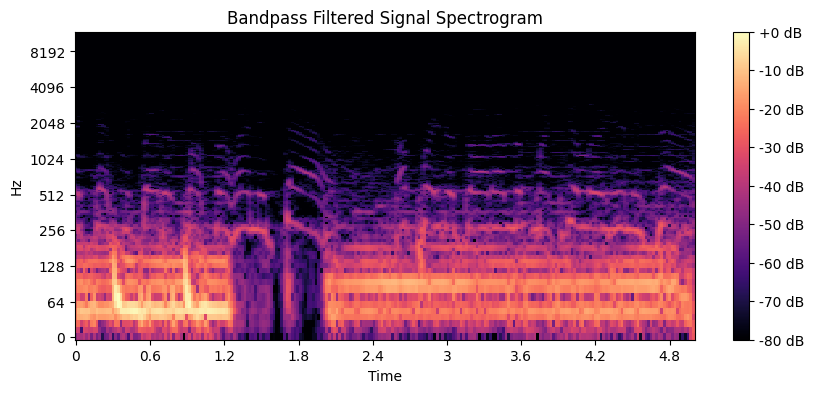

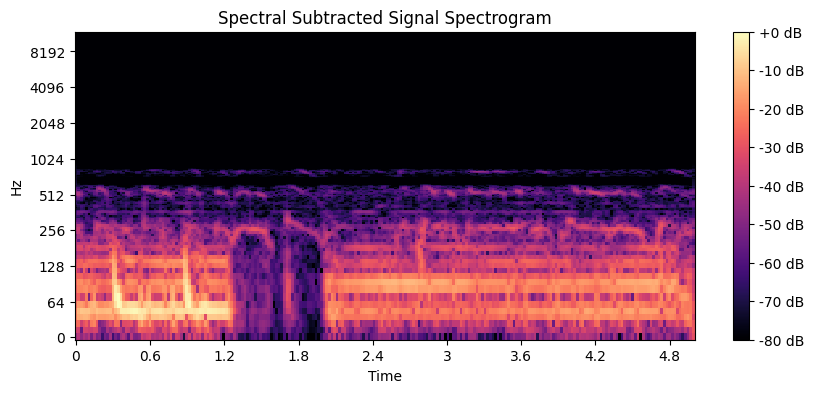

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

def plot_spectrogram(signal, sr, title="Spectrogram"):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Apply bandpass filter
filtered_signal = bandpass_filter(wav[0].detach().numpy(), lowcut=10, highcut=100, fs=sample_rate, order = 2)

# Apply spectral subtraction
subtracted_signal = spectral_subtraction(filtered_signal, alpha=1.0)

# Plot original signal
plot_spectrogram(wav[0].detach().numpy(), sample_rate, title="Original Signal Spectrogram")

# Plot bandpass filtered signal
plot_spectrogram(filtered_signal, sample_rate, title="Bandpass Filtered Signal Spectrogram")

# Plot spectral subtracted signal
plot_spectrogram(subtracted_signal, sample_rate, title="Spectral Subtracted Signal Spectrogram")

## Librosa Harmonic and Percusive Seperation
#### Testing another method to extract the beat

Harmonic Signal:


Percussive Signal:


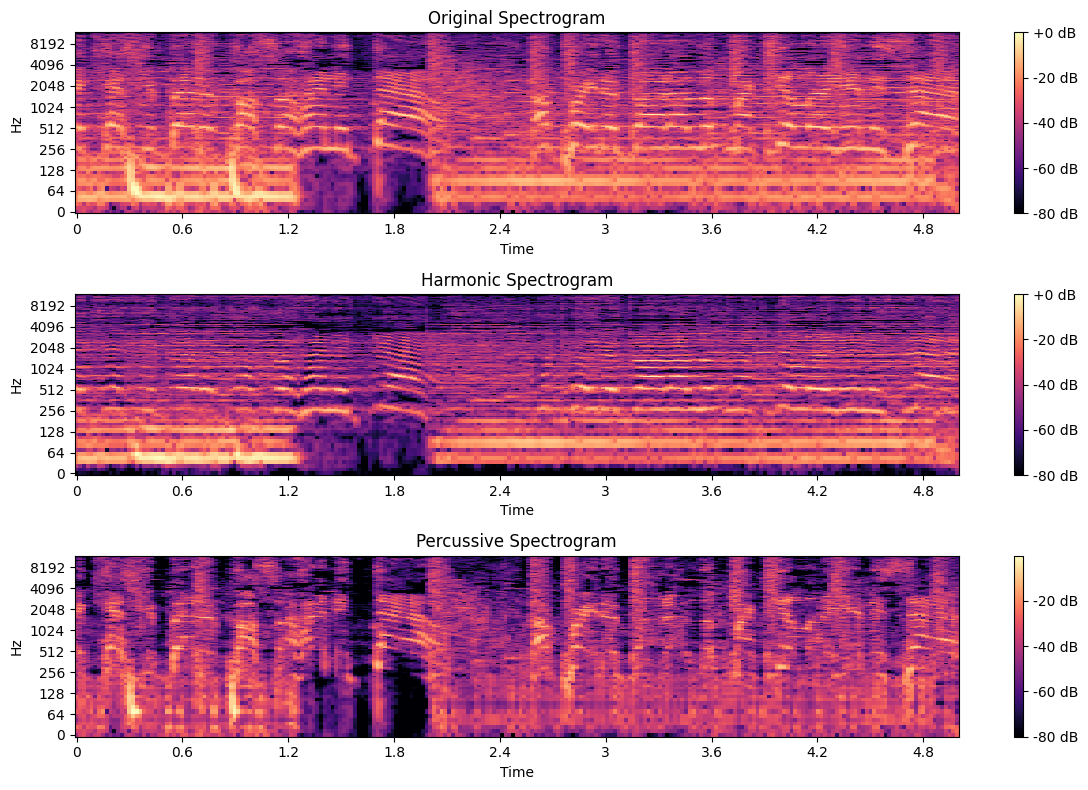

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

audio_codes, pose, pose_mask, wav, wav_mask, wav_path, sample_rate = train_dataset[100]
sr = sample_rate

spec = np.abs(librosa.stft(wav[0].detach().numpy()))

# Perform harmonic and percussive separation
harmonic, percussive = librosa.decompose.hpss(spec)

# Convert back to time domain
harmonic_audio = librosa.griffinlim(harmonic)
percussive_audio = librosa.griffinlim(percussive)

print("Harmonic Signal:")
display(Audio(harmonic_audio, rate=sr))
print("Percussive Signal:")
display(Audio(percussive_audio, rate=sr))

# Plotting the waveforms/spectrograms
plt.figure(figsize=(12, 8))

# Plot the original spectrogram
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

# Plot the harmonic spectrogram
plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(harmonic, ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Harmonic Spectrogram')

# Plot the percussive spectrogram
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(percussive, ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Percussive Spectrogram')

plt.tight_layout()
plt.show()

## Seperate the vocals from the isntruments using Spleeter

In [ ]:
# instructions for installing spleeter on macOS m2 chip
# https://github.com/deezer/spleeter/issues/696

# install using pip if you're not using a mac m1-3 chip
# !pip install spleeter
import soundfile as sf
from spleeter.separator import Separator

### 2 Stem extraction

In [ ]:
audio_codes, pose, pose_mask, wav, wav_mask, wav_path, sample_rate = train_dataset[50]
print(wav.shape, wav_path)

# Convert the torch tensor to a numpy array and save as a .wav file
audio_data = wav[0].detach().numpy()
temp_audio_path = 'spleeter_input/temp_input_audio.wav'
sf.write(temp_audio_path, audio_data, sample_rate)

# Initialize Spleeter
separator = Separator('spleeter:2stems')

# Use Spleeter to separate the audio file
separator.separate_to_file(temp_audio_path, 'spleeter_output')

# If you need to load the separated audio back into Python
vocals_path = 'spleeter_output/temp_input_audio/vocals.wav'
instrumental_path = 'spleeter_output/temp_input_audio/accompaniment.wav'

vocals, _ = librosa.load(vocals_path, sr=sample_rate, mono=True)
instrumental, _ = librosa.load(instrumental_path, sr=sample_rate, mono=True)

print("Original:")
display(Audio(audio_data, rate=sample_rate))
print("Vocals:")
display(Audio(vocals, rate=sample_rate))
print("Instrumental:")
display(Audio(instrumental, rate=sample_rate))

torch.Size([1, 120001]) /Users/azeez/Documents/pose_estimation/DanceToMusicApp/ml/data/samples/5sec_expando_dataset/youtube_links_59_20_sample/youtube_links_59_20.wav
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Using config: {'_model_dir': 'pretrained_models/2stems', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.7
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_mas

Vocals:


Instrumental:


### 4 Stem Extraction

In [ ]:
# Assuming you have a PyTorch dataset named `train_dataset`
audio_codes, pose, pose_mask, wav, wav_mask, wav_path, sample_rate = train_dataset[43]
print(wav.shape, wav_path)

# Convert the torch tensor to a numpy array and save as a .wav file
audio_data = wav[0].detach().numpy()
temp_audio_path = 'temp_input_audio.wav'
sf.write(temp_audio_path, audio_data, sample_rate)

# Initialize Spleeter with 4-stems model
separator = Separator('spleeter:4stems')

# Use Spleeter to separate the audio file
separator.separate_to_file(temp_audio_path, 'spleeter_output')

# Construct paths for the separated audio
output_dir = 'spleeter_output/temp_input_audio'
vocals_path = f'{output_dir}/vocals.wav'
drums_path = f'{output_dir}/drums.wav'
bass_path = f'{output_dir}/bass.wav'
other_path = f'{output_dir}/other.wav'

# Load the separated audio back into Python
vocals, _ = librosa.load(vocals_path, sr=sample_rate, mono=True)
drums, _ = librosa.load(drums_path, sr=sample_rate, mono=True)
bass, _ = librosa.load(bass_path, sr=sample_rate, mono=True)
other, _ = librosa.load(other_path, sr=sample_rate, mono=True)

# Combine drums and bass tracks
drum_and_bass = drums + bass

# Save the combined drum and bass track
combined_path = f'{output_dir}/drum_and_bass.wav'
sf.write(combined_path, drum_and_bass, sample_rate)

# Displaying the audio
print("Original:")
display(Audio(audio_data, rate=sample_rate))
print("Vocals:")
display(Audio(vocals, rate=sample_rate))
print("Drums:")
display(Audio(drums, rate=sample_rate))
print("Bass:")
display(Audio(bass, rate=sample_rate))
print("Other Instruments:")
display(Audio(other, rate=sample_rate))
print("Drums and Bass:")
display(Audio(drum_and_bass, rate=sample_rate))

torch.Size([1, 120001]) /Users/azeez/Documents/pose_estimation/DanceToMusicApp/ml/data/samples/5sec_expando_dataset/youtube_links_28_14_sample/youtube_links_28_14.wav
INFO:tensorflow:Using config: {'_model_dir': 'pretrained_models/4stems', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.7
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replica

Exception ignored in: <generator object Estimator.predict at 0x36cbf6030>
Traceback (most recent call last):
  File "/Users/azeez/miniforge3/envs/dance2music/lib/python3.10/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
    with tf.Graph().as_default() as g:
  File "/Users/azeez/miniforge3/envs/dance2music/lib/python3.10/contextlib.py", line 153, in __exit__
    self.gen.throw(typ, value, traceback)
  File "/Users/azeez/miniforge3/envs/dance2music/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 4573, in get_controller
    with super(_DefaultGraphStack,
  File "/Users/azeez/miniforge3/envs/dance2music/lib/python3.10/contextlib.py", line 153, in __exit__
    self.gen.throw(typ, value, traceback)
  File "/Users/azeez/miniforge3/envs/dance2music/lib/python3.10/site-packages/tensorflow/python/framework/stack.py", line 59, in get_controller
    raise AssertionError(
AssertionError: Nesting violated for default stack of <class 't

INFO:tensorflow:Apply unet for bass_spectrogram
INFO:tensorflow:Apply unet for other_spectrogram
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from pretrained_models/4stems/model
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:spleeter:File spleeter_output/temp_input_audio/drums.wav written succesfully
INFO:spleeter:File spleeter_output/temp_input_audio/other.wav written succesfully
INFO:spleeter:File spleeter_output/temp_input_audio/vocals.wav written succesfully
INFO:spleeter:File spleeter_output/temp_input_audio/bass.wav written succesfully
Original:


Vocals:


Drums:


Bass:


Other Instruments:


Drums and Bass:
